# Task: Image compression
Analyze the three images present on ILIAS to decide which compression strategy is
the most promising one. Below, we suggest two such strategies, namely 2D run-length
encoding and quadtree representation. Choose one of them, or yet another strategy of
your own design. Regardless of the compression method you choose, write an algorithm
to decompress the image back to the original image.

In [87]:
#Imports
from __future__ import annotations

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#If set to true, this pass will save all images to output
save: bool = True
save_index = 0

def save_plot(image_name: str):
    """Save the plot under the image name if 'save' parameter is true"""
    global save_index
    
    if save:
        plt.savefig(f'./out/{save_index}_{image_name}.png')
        save_index += 1

In [88]:
from cv2 import Mat
from enum import Enum

class QuadTree:
    image: Mat
    image_dimension: tuple = None
    root_partitions: list[QuadTreeNode]
    root_partition_size: tuple[int, int]

    class ControlByteSize(Enum):
        DIMENSION = 4
        PARTITION_SIZE = 2

    def __init__(self, image: Mat | None) -> None:
        self.image = image
        self.image_dimension = None if image is None else image.shape
        self.root_partitions = []

    def build_quad(self, roots_shape: tuple):
        self.root_partition_size = roots_shape
        image_width, image_height, _ = self.image.shape
        root_w, root_h = roots_shape

        print(f"Processing image {image_width}*{image_height}")

        if image_width % root_w != 0:
            raise Exception(f"Can not partition image with width {image_width} by partition of width {root_w}")
        if image_height % root_h != 0:
            raise Exception(f"Can not partition image with height {image_height} by partition of height {root_h}")
        
        if root_w != root_h:
            raise Exception(f"Can not partition image with partition shape {roots_shape} as it is not square")
        
        log2_root_w = np.log2(root_w)
        if np.ceil(log2_root_w) != np.floor(log2_root_w):
            raise Exception(f"Can not partition image with shape {roots_shape} as it is not a power of 2")
        
        #Start the quad tree's roots, each root building its children recursively
        for x in range(0, image_width, root_w):
            for y in range(0, image_height, root_h):
                x1,x2 = x, x+root_w
                y1,y2 = y, y+root_h
                image_partition = self.image[x1:x2, y1:y2]
                self.root_partitions.append(QuadTreeNode().build_from_image(image_partition, (x1, x2, y1, y2)))
        
        total_encoded = sum([root.count_encoded_patches() for root in self.root_partitions])
        print(f"Original image size: {image_width*image_height}, encoded patches: {total_encoded}")
    
    def show_tree_at_depth(self, depth: int):
        """"""
        #Create canvas as blank copy of image
        canvas = np.zeros(self.image_dimension, np.uint8)

        #Ask nodes to fill it at level N
        for root in self.root_partitions:
            x1, x2, y1, y2 = root.local_coordinates
            canvas_subpartition = canvas[x1:x2, y1:y2]
            root.color_patch_recursive(canvas_subpartition, depth)

        return canvas
    
    def activation_map(self, depth: int):
        """"""
        #Create canvas as blank copy of image
        canvas = np.zeros_like(self.image)

        #Ask nodes to fill it at level N
        for root in self.root_partitions:
            x1, x2, y1, y2 = root.local_coordinates
            canvas_subpartition = canvas[x1:x2, y1:y2]
            root.color_activation_map(canvas_subpartition, depth)

        return canvas
    
    def serialize(self) -> bytearray:
        """Serialize the tree to a byte array
        
        Returns
        ----
            The tree as a byte array
        """
        binary_string = bytearray()

        ##Control/Metadata bytes##
        #Serialize image size
        w,h,_ = self.image.shape
        binary_string.extend(list(w.to_bytes(QuadTree.ControlByteSize.DIMENSION.value, 'big')))
        binary_string.extend(list(h.to_bytes(QuadTree.ControlByteSize.DIMENSION.value, 'big')))
        #Serialize partition size
        partition_w, partition_h = self.root_partition_size
        binary_string.extend(list(partition_w.to_bytes(QuadTree.ControlByteSize.PARTITION_SIZE.value, 'big')))
        binary_string.extend(list(partition_h.to_bytes(QuadTree.ControlByteSize.PARTITION_SIZE.value, 'big')))

        #Append every node to the byte array
        for root in self.root_partitions:
            root.serialize_to(binary_string)

        return binary_string 

    @classmethod
    def deserialize(cls, byte_array: bytearray) -> QuadTree:
        """Deserialize the bytearray, create a new QuadTree"""
        quad_tree = QuadTree(None)
        # Control bytes #
        image_width, byte_array = int.from_bytes(byte_array[:QuadTree.ControlByteSize.DIMENSION.value], 'big'), byte_array[QuadTree.ControlByteSize.DIMENSION.value:]
        image_height, byte_array = int.from_bytes(byte_array[:QuadTree.ControlByteSize.DIMENSION.value], 'big'), byte_array[QuadTree.ControlByteSize.DIMENSION.value:]
        root_w, byte_array = int.from_bytes(byte_array[:QuadTree.ControlByteSize.PARTITION_SIZE.value], 'big'), byte_array[QuadTree.ControlByteSize.PARTITION_SIZE.value:]
        root_h, byte_array = int.from_bytes(byte_array[:QuadTree.ControlByteSize.PARTITION_SIZE.value], 'big'), byte_array[QuadTree.ControlByteSize.PARTITION_SIZE.value:]

        #Start the quad tree's roots, each root building its children recursively
        for x in range(0, image_width, root_w):
            for y in range(0, image_height, root_h):
                x1,x2 = x, x+root_w
                y1,y2 = y, y+root_h
                quad_tree.root_partitions.append(QuadTreeNode().deserialize(byte_array, (x1,x2, y1,y2)))

        #Finally: Now that the nodes are built, they can re-generate the image losslessly
        quad_tree.image_dimension = (image_width, image_height, 3)
        quad_tree.image = quad_tree.show_tree_at_depth(image_width/root_w)
        return quad_tree

class QuadTreeNode:
    image_partition: Mat | None
    local_coordinates: tuple | None

    children: list[QuadTreeNode] | None
    color: tuple[int, int, int] | None
    mean_color: tuple[int, int, int] | None

    class NodeType(Enum):
        COLOR_PATCH = 0
        CHILDREN_PATCH = 1

    def __init__(self) -> None:
        self.children = None
        self.mean_color = None
        self.color = None
    
    def build_from_image(self, image_partition: Mat, local_coordinates: tuple) -> QuadTreeNode:
        """Build the node recursively, create new nodes if necessary. Automatically called when creating a node on an image"""
        self.image_partition = image_partition
        self.local_coordinates = local_coordinates

        w,h,_ = self.image_partition.shape
        
        r,g,b = self.image_partition[0,0]
        reference_pix = (r,g,b)

        #Compare pach's pixel values only if necessary
        if w==1 and h==1:
            self.color = reference_pix
            return self
        
        #Non-trival case: Do we stop or do we go further = For that, test uniformity of internal pixels
        mask_result = np.zeros_like(self.image_partition)
        #This creates a boolean mask and apply the mask to the image partition. The 'true' results are given the value 1.
        mask_result[self.image_partition != reference_pix] = 1 

        #At least one pix is not the same, decompose in children
        if np.any(mask_result):
            partitions_coordinates = self.get_children_coordinates()

            self.children = []
            for partition_coordinate in partitions_coordinates:
                x1,x2, y1,y2 = partition_coordinate
                image_subpartition = self.image_partition[x1:x2, y1:y2]
                child = QuadTreeNode().build_from_image(image_subpartition, partition_coordinate)
                self.children.append(child)
            #Compute mean-color immediatly in order to not have to re-compute it each time afterwards in case of partial display of the quadtree
            self.mean_color = self.color_or_mean()
        else:
            self.color = reference_pix

        return self
    
    def get_children_coordinates(self) -> list[tuple]:
        """Compute the coordinates of the 4 children of this node from its local coordinates"""
        #Cut 4 equal shapes
        x1, x2, y1, y2 = self.local_coordinates
        w,h = x2-x1, y2-y1
        half_w, half_h = int(w/2), int(h/2)

        return [
            (0, half_w, 0, half_h),
            (half_w, w, 0, half_h),
            (0, half_w, half_h, h),
            (half_w, w, half_h, h)
        ]

    def serialize_to(self, byte_array: bytearray) -> None:
        """Append this patch and its children to the given byte array object"""
        if self.children is not None:
            byte_array.append(QuadTreeNode.NodeType.CHILDREN_PATCH.value)
            for child in self.children:
                child.serialize_to(byte_array)
        else:
            byte_array.append(QuadTreeNode.NodeType.COLOR_PATCH.value)
            r,g,b = np.array(self.color, dtype=np.uint8)
            byte_array.extend([r, g, b])

    def deserialize(self, byte_array: bytearray, local_coordinates: tuple) -> QuadTreeNode:
        """Build the node recursively from a byte array"""
        self.local_coordinates = local_coordinates
        #Get this node type from the BA
        node_type = byte_array.pop(0)
        
        if node_type == QuadTreeNode.NodeType.COLOR_PATCH.value:
            rgb = (byte_array.pop(0), byte_array.pop(0), byte_array.pop(0))
            self.color = rgb
        elif node_type == QuadTreeNode.NodeType.CHILDREN_PATCH.value:
            self.children = []
            children_coordinates = self.get_children_coordinates()
            for children_coordinate in children_coordinates:
                child = QuadTreeNode().deserialize(byte_array, children_coordinate)
                self.children.append(child)
            #Compute mean-color immediatly in order to not have to re-compute it each time afterwards in case of partial display of the quadtree
            self.mean_color = self.color_or_mean()        
        
        else:
            raise ValueError(f"Unexpected value when reading quad tree node type: {node_type}")
        
        return self

    def color_patch_recursive(self, canvas_partition: Mat, depth: int | None) -> None:
        """Color the given patch. Recursive function with stop condition on depth to alow partial  
        If the patch is uniform, simply color the canvas partition with the given color.
        If the patch is not uniform:
            * If depth is >0, color sub-patches
            * If depth =0, color with mean color of this patch 
        
        """
        if self.color is not None:
            canvas_partition[:,:] = self.color
        else:
            if depth <= 0:
                canvas_partition[:,:] = self.mean_color
            else:
                for child in self.children:
                    x1, x2, y1, y2 = child.local_coordinates
                    canevas_subpartition = canvas_partition[x1:x2, y1:y2]
                    child.color_patch_recursive(canevas_subpartition, depth-1)
    
    def color_activation_map(self, canvas_partition: Mat, depth: int | None) -> None:
        """Color the given patch in red if it is activated at this level"""
        if depth <= 0:
            if self.children is None:
                canvas_partition[:,:] = (220,20,60)
        else:
            if self.children is not None:
                for child in self.children:
                    x1, x2, y1, y2 = child.local_coordinates
                    canevas_subpartition = canvas_partition[x1:x2, y1:y2]
                    child.color_activation_map(canevas_subpartition, depth-1)

    def color_or_mean(self) -> tuple[int, int, int]:
        """Return the color of this patch
        
        Returns
        -----
            Color as RGB if this patch is uniform, mean of the children's colors if the patch has children"""
        if self.color:
            return self.color

        colors = [child.color_or_mean() for child in self.children]
        return np.array(colors).mean(0)

    def count_encoded_patches(self):
        #Trivial case: We are a single patch
        if self.color is not None:
            return 1
        
        return sum([child.count_encoded_patches() for child in self.children])

test

In [89]:
# Change variables here
image_name = "page-SD3-1003.png"

partition_size = (64,64)

In [90]:
image = cv2.imread(f'./in/{image_name}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

quadTree = QuadTree(image)

quadTree.build_quad(partition_size)

Processing image 448*320
Original image size: 143360, encoded patches: 19085


* Test: See all subpartitions by calling the color method with a depth of 0 (no children called)

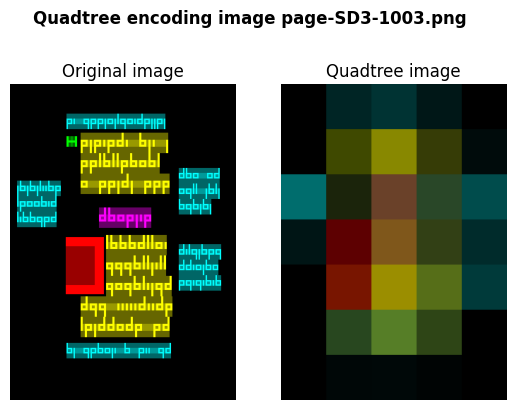

In [91]:
colored_roots = quadTree.show_tree_at_depth(0)

fig, ax = plt.subplots(1, 2)
fig.suptitle(f'Quadtree encoding image {image_name}', fontweight='bold')

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(colored_roots)
ax[1].set_title('Quadtree image')
ax[1].set_axis_off()

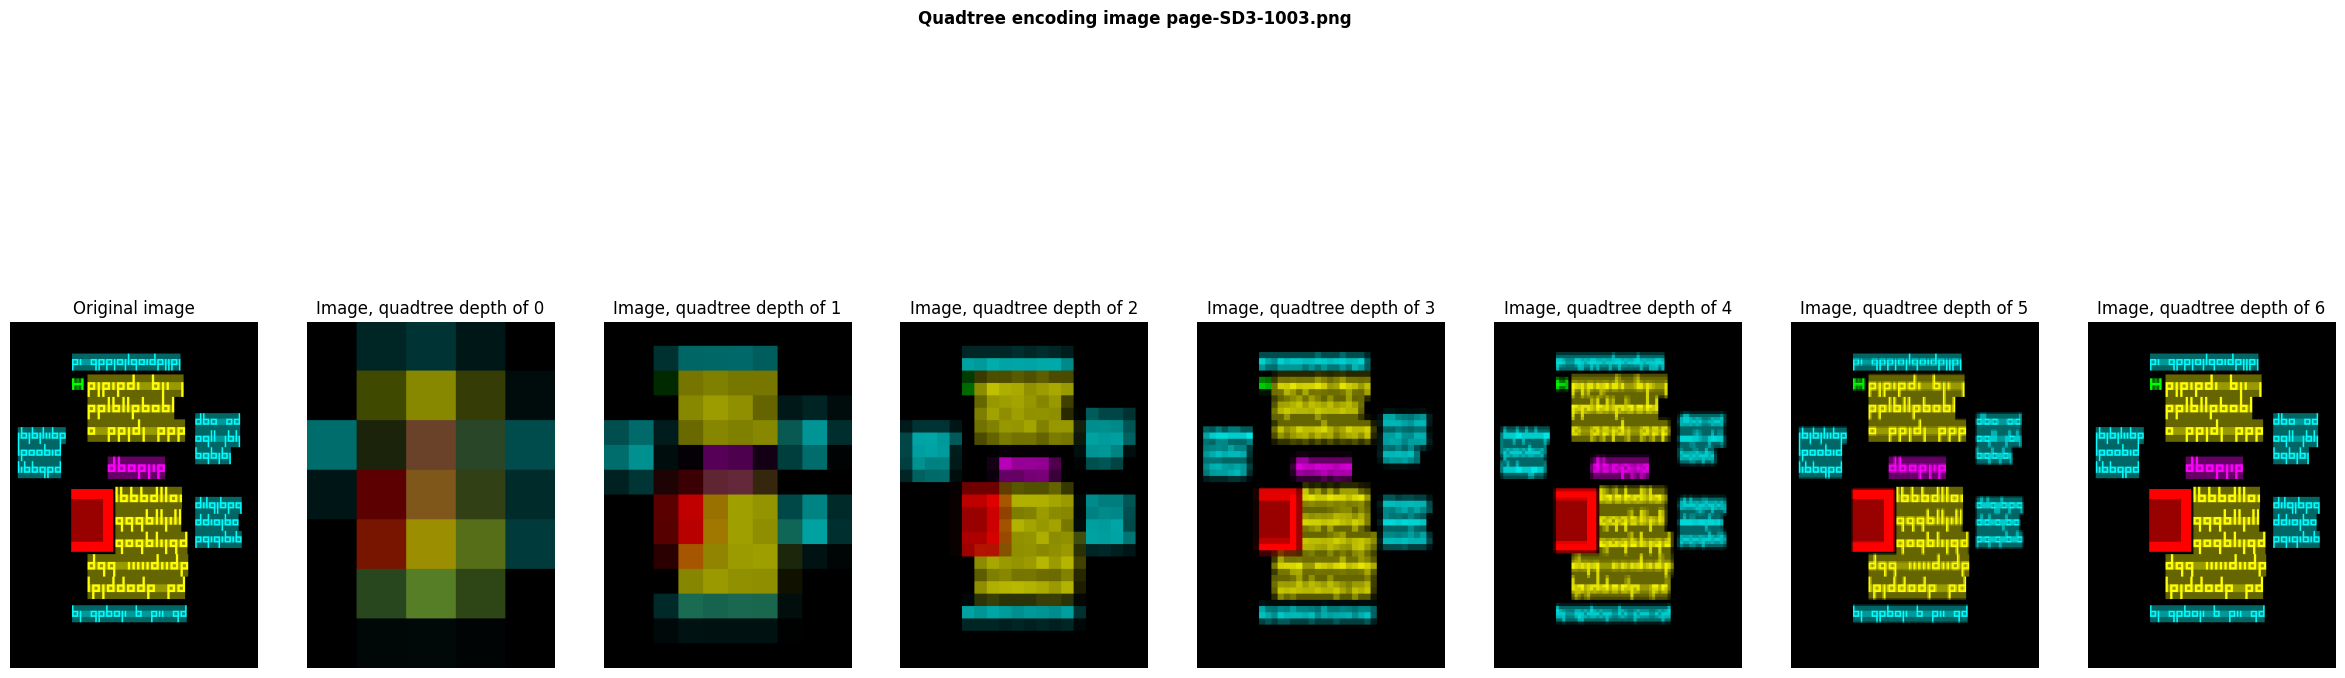

In [92]:
iterative_images = []
min_dim_size = partition_size[0] #Square dimensions, just take one side
iteration_index = 0
while min_dim_size>=1:
    iterative_images.append(quadTree.show_tree_at_depth(iteration_index))
    min_dim_size /= 2
    iteration_index += 1


fig, ax = plt.subplots(1, len(iterative_images) + 1, figsize=(30,10))
fig.suptitle(f'Quadtree encoding image {image_name}', fontweight='bold')

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].set_axis_off()

for i, iter_image in enumerate(iterative_images):
    ax[i+1].imshow(iter_image)
    ax[i+1].set_title(f'Image, quadtree depth of {i}')
    ax[i+1].set_axis_off()

save_plot(f"iterative_quad_tree_{image_name}")

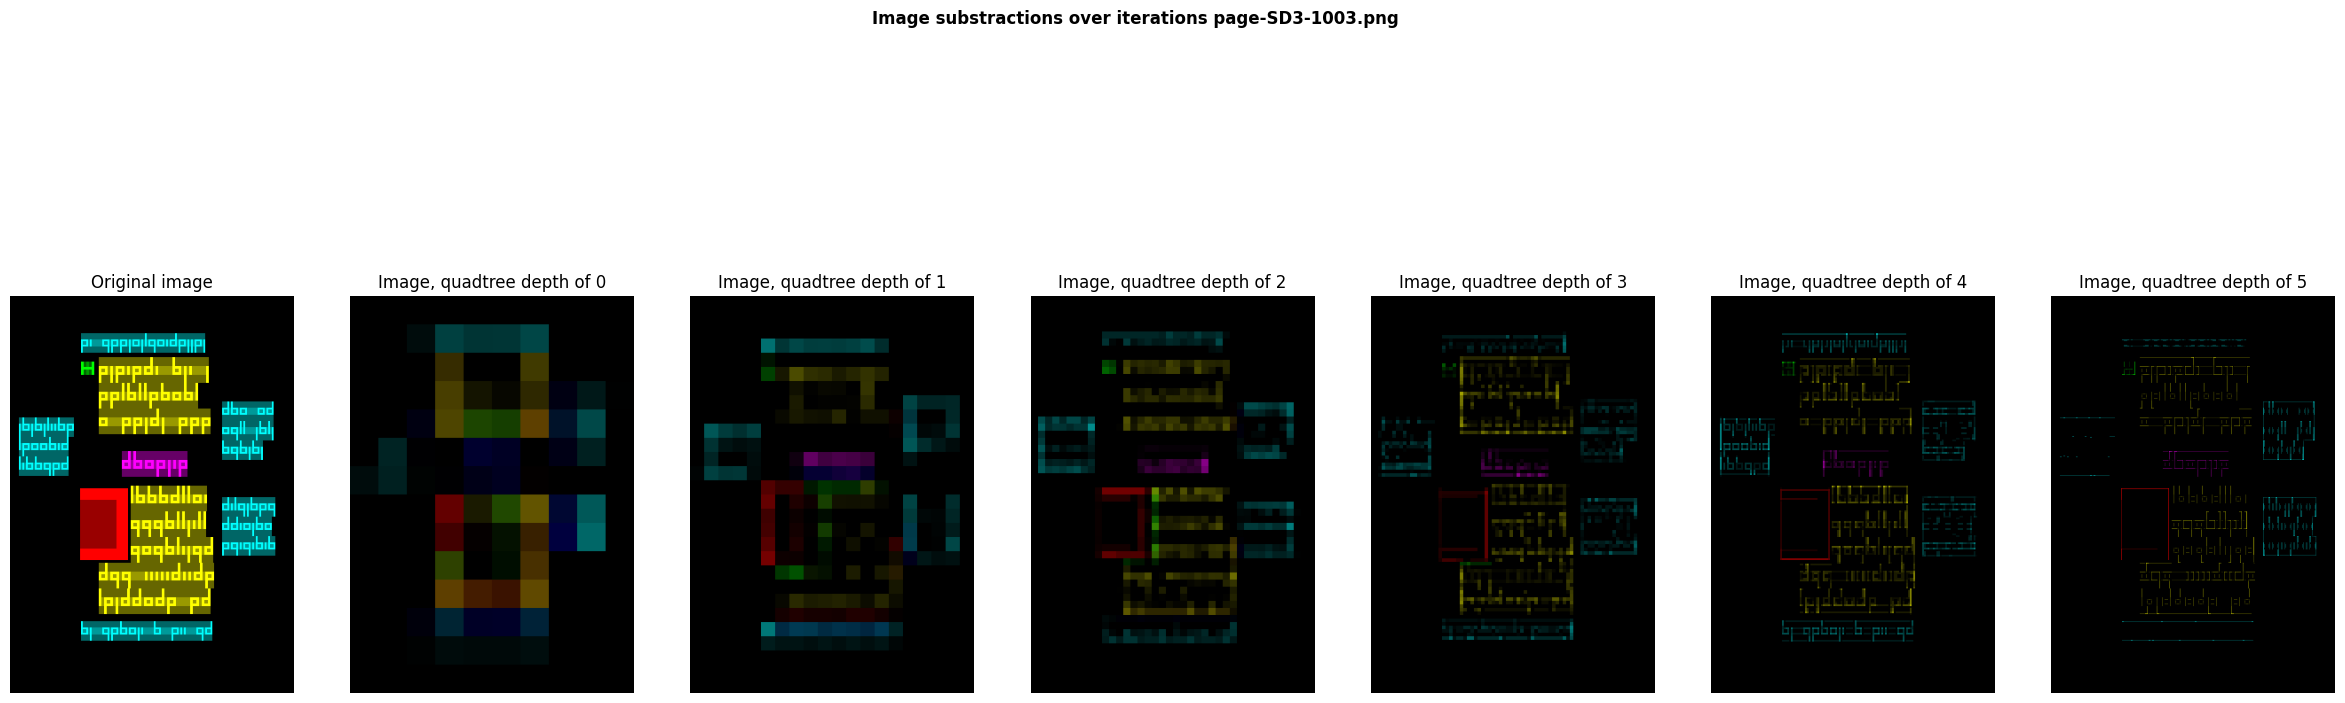

In [93]:
iterative_images = []
min_dim_size = partition_size[0] #Square dimensions, just take one side
iteration_index = 0
while min_dim_size>=1:
    iterative_images.append(quadTree.show_tree_at_depth(iteration_index))
    min_dim_size /= 2
    iteration_index += 1


fig, ax = plt.subplots(1, len(iterative_images), figsize=(30,10))
fig.suptitle(f'Image substractions over iterations {image_name}', fontweight='bold')

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].set_axis_off()

for i in range(len(iterative_images)-1):
    sub_im = cv2.subtract(iterative_images[i+1], iterative_images[i])
    ax[i+1].imshow(sub_im)
    ax[i+1].set_title(f'Image, quadtree depth of {i}')
    ax[i+1].set_axis_off()

save_plot(f"iterative_differences_{image_name}")

# As this is an important step, test serialization / deserialization on trivial quad tree

Processing image 2*2
Original image size: 4, encoded patches: 4


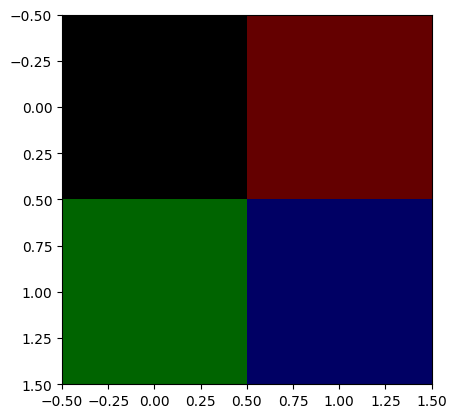

In [94]:
test_image = np.array([[(0,0,0),(100,0,0)],[(0,100,0),(0,0,100)]])
qt = QuadTree(test_image)
qt.build_quad((2,2))

plt.imshow(qt.show_tree_at_depth(2))

In [95]:
ds = qt.serialize()

In [96]:
qt2 = QuadTree.deserialize(ds)

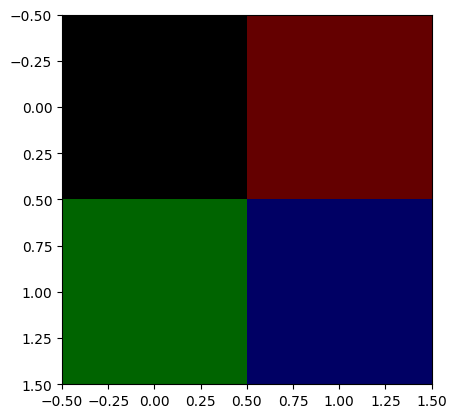

In [97]:
plt.imshow(qt2.show_tree_at_depth(2))

# Go back to real image

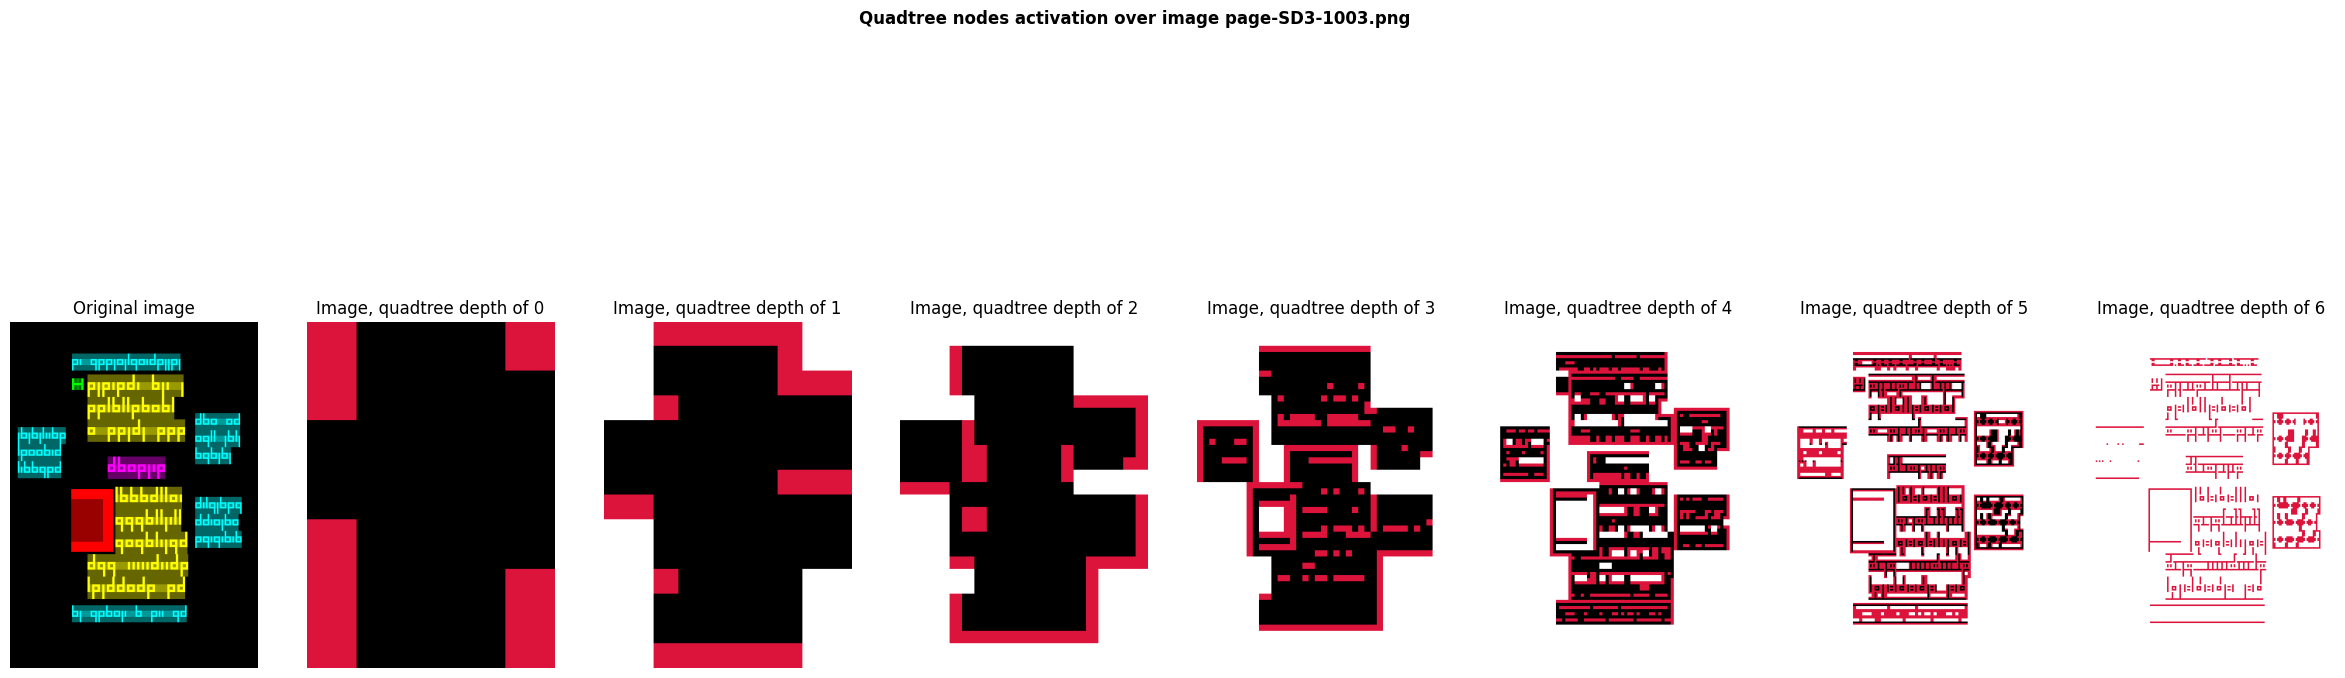

In [98]:
iterative_images = []
min_dim_size = partition_size[0] #Square dimensions, just take one side
iteration_index = 0
while min_dim_size>=1:
    iterative_images.append(quadTree.activation_map(iteration_index))
    min_dim_size /= 2
    iteration_index += 1


fig, ax = plt.subplots(1, len(iterative_images)+1, figsize=(30,10))
fig.suptitle(f'Quadtree nodes activation over image {image_name}', fontweight='bold')

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].set_axis_off()


iterative_activation_image = np.zeros_like(image)
for i in range(len(iterative_images)):
    #Extract current image, display the addition of both
    current_activation_image = iterative_images[i]
    ax[i+1].imshow(np.add(iterative_activation_image, current_activation_image))
    ax[i+1].set_title(f'Image, quadtree depth of {i}')
    ax[i+1].set_axis_off()
    #Add current activation map to iterative one, as white pixels
    current_activation_image[current_activation_image[:,:] != (0,0,0)] = 255
    iterative_activation_image = np.add(iterative_activation_image, current_activation_image)

save_plot(f"iterative_activation_map_{image_name}")

In [99]:
serialized_image = quadTree.serialize()

serialized_size_bytes = len(serialized_image)
serialized_size_kbytes = np.round(serialized_size_bytes/1000, 3)
image_size_kbytes = np.round(image.size/1000, 3)

print(f"Image size: {image_size_kbytes} kb")
print(f"Quadtree stored size: {serialized_size_kbytes}kb")
print(f"Ratio: The size is reduced by a factor or {np.round(image.size/serialized_size_bytes,2)}")
print(f"New storage takes only {100*np.round(serialized_size_bytes/image.size, 2)}% of RGB storage")

with open(f"./out/serialized_{image_name}.bin", "wb") as f:
    f.write(serialized_image)

Image size: 430.08 kb
Quadtree stored size: 82.702kb
Ratio: The size is reduced by a factor or 5.2
New storage takes only 19.0% of RGB storage


Rebuilt image from serialized tree

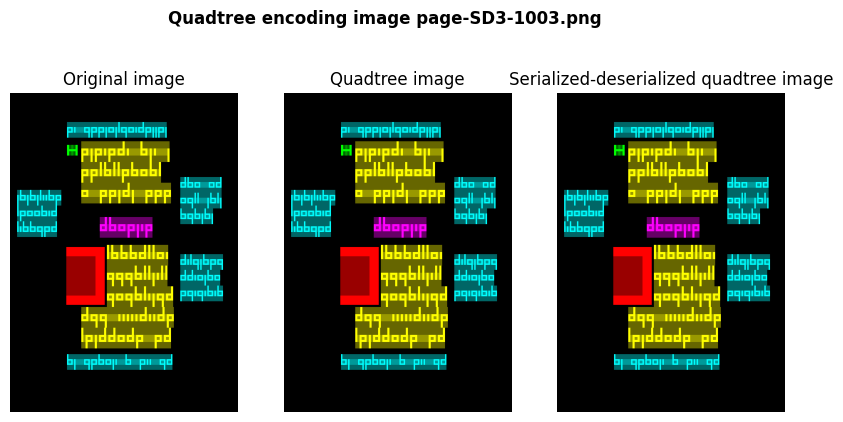

In [104]:
rebuilt_quad_tree = QuadTree.deserialize(serialized_image)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle(f'Quadtree encoding image {image_name}', fontweight='bold')

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(quadTree.show_tree_at_depth(20))
ax[1].set_title('Quadtree image')
ax[1].set_axis_off()

ax[2].imshow(rebuilt_quad_tree.show_tree_at_depth(20))
ax[2].set_title('Serialized-deserialized quadtree image')
ax[2].set_axis_off()

save_plot(f"rebuilt_image{image_name}")